<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week8.do.txt --no_mako --no_abort -->
<!-- dom:TITLE: Week 10, March 4-8: Resampling Techniques, Bootstrap and Blocking -->

# Week 10, March 4-8: Resampling Techniques, Bootstrap and Blocking
**Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no**, Department of Physics and Center fo Computing in Science Education, University of Oslo, Oslo, Norway and Department of Physics and Astronomy and Facility for Rare Ion Beams, Michigan State University, East Lansing, Michigan, USA

Date: **March 4-8**

## Overview of week 10, March 4-8
**Topics.**

1. Reminder on optimization methods and top-down approach to what we need to add

2. Resampling Techniques and statistics: Bootstrap and Blocking

3. Discussion of codes
<!-- * [Video of lecture to be added](https://youtu.be/) -->
<!-- * [Handwritten notes](https://github.com/CompPhysics/ComputationalPhysics2/blob/gh-pages/doc/HandWrittenNotes/2024/NotesMarch8.pdf) -->

**Teaching Material, videos and written material.**

* Overview video on the [Bootstrap method](https://www.youtube.com/watch?v=O_Fj4q8lgmc&ab_channel=MarinStatsLectures-RProgramming%26Statistics)

* [Marius Johnson's Master thesis on the Blocking Method](https://www.duo.uio.no/bitstream/handle/10852/68360/PhysRevE.98.043304.pdf?sequence=2&isAllowed=y)

## Top-down approach, what we need to code

### Final code for the two-electron case

The code here uses the BFGS algorithm but performs now a
production run and writes to file all average values of the
energy.

In [1]:
%matplotlib inline

# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added energy minimization
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import minimize
import sys
import os

# Where to save data files
PROJECT_ROOT_DIR = "Results"
DATA_ID = "Results/EnergyMin"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

outfile = open(data_path("Energies.dat"),'w')


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha,beta):
    
    WfDer  = np.zeros((2), np.double)
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    WfDer[0] = -0.5*(r1+r2)
    WfDer[1] = -r12*r12*deno2
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce
    

# Computing the derivative of the energy and the energy 
def EnergyDerivative(x0):

    
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    EnergyDer = 0.0
    DeltaPsi = 0.0
    DerivativePsiE = 0.0 
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        DerPsi = DerivativeWFansatz(PositionOld,alpha,beta)
        DeltaPsi += DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return EnergyDer


# Computing the expectation value of the local energy 
def Energy(x0):
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        energy += DeltaE
        if Printout: 
           outfile.write('%f\n' %(energy/(MCcycle+1.0)))            
    # We calculate mean values
    energy /= NumberMCcycles
    return energy

#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# seed for rng generator 
seed()
# Monte Carlo cycles for parameter optimization
Printout = False
NumberMCcycles= 10000
# guess for variational parameters
x0 = np.array([0.9,0.2])
# Using Broydens method to find optimal parameters
res = minimize(Energy, x0, method='BFGS', jac=EnergyDerivative, options={'gtol': 1e-4,'disp': True})
x0 = res.x
# Compute the energy again with the optimal parameters and increased number of Monte Cycles
NumberMCcycles= 2**19
Printout = True
FinalEnergy = Energy(x0)
EResult = np.array([FinalEnergy,FinalEnergy])
outfile.close()
#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
data ={'Optimal Parameters':x0, 'Final Energy':EResult}
frame = pd.DataFrame(data)
print(frame)

/Users/mhjensen/miniforge3/envs/myenv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 2.997648
         Iterations: 3
         Function evaluations: 23
         Gradient evaluations: 11
   Optimal Parameters  Final Energy
0            0.996382      3.000432
1            0.421734      3.000432


Note that the **minimize** function returns the final values for the
variable $\alpha=x0[0]$ and $\beta=x0[1]$ in the array $x$.

When we have found the minimum, we use these optimal parameters to
perform a production run of energies.  The output is in turn written
to file and is used, together with resampling methods like the
**blocking method**, to obtain the best possible estimate for the
standard deviation.  The optimal minimum is, even with our guess,
rather close to the exact value of $3.0$ a.u.

Our next step is to use the output values of the energy and
perform a blocking analysis of the results in order to get
a best possible estimate of the standard deviation.

## Resampling analysis

The next step is then to use the above data sets and perform a
resampling analysis, either using say the Bootstrap method or the
Blocking method.

In [4]:
# Common imports
import os

# Where to save the figures and data files
DATA_ID = "Results/EnergyMin"

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

infile = open(data_path("Energies.dat"),'r')

from numpy import std, mean, concatenate, arange, loadtxt, zeros, ceil
from numpy.random import randint
from time import time


def tsboot(data,statistic,R,l):
    t = zeros(R); n = len(data); k = int(ceil(float(n)/l));
    inds = arange(n); t0 = time()
    
    # time series bootstrap
    for i in range(R):
        # construct bootstrap sample from
        # k chunks of data. The chunksize is l
        _data = concatenate([data[j:j+l] for j in randint(0,n-l,k)])[0:n];
        t[i] = statistic(_data)

    # analysis
    print ("Runtime: %g sec" % (time()-t0)); print ("Bootstrap Statistics :")
    print ("%8g %14g %15g" % (statistic(data), \
                             mean(t) - statistic(data), \
                             std(t) ))
    
#    print ("Runtime: %g sec" % (time()-t0)); print ("Bootstrap Statistics :")
#    print ("%8g %15g" % (statistic(data), std(t) )
    return t
# Read in data
X = loadtxt(infile)
# statistic to be estimated. Takes two args.
# arg1: the data
def stat(data):
    return mean(data)
t = tsboot(X, stat, 2**12, 2**10)

Runtime: 3.57637 sec
Bootstrap Statistics :
 3.00034    2.64425e-07     2.06261e-05


The blocking code, based on the article of [Marius Jonsson](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.98.043304) is given here

In [5]:
# Common imports
import os

# Where to save the figures and data files
DATA_ID = "Results/EnergyMin"

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

infile = open(data_path("Energies.dat"),'r')

from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, sqrt
from numpy.linalg import inv

def block(x):
    # preliminaries
    n = len(x)
    d = int(log2(n))
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)

    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])
   
    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,9.210340, 11.344867, 13.276704, 15.086272, 16.811894, 18.475307, 20.090235, 21.665994, 23.209251, 24.724970, 26.216967, 27.688250, 29.141238, 30.577914, 31.999927, 33.408664, 34.805306, 36.190869, 37.566235, 38.932173, 40.289360, 41.638398, 42.979820, 44.314105, 45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")
    return mu, s[k]/2**(d-k)


x = loadtxt(infile)
(mean, var) = block(x) 
std = sqrt(var)
import pandas as pd
from pandas import DataFrame
data ={'Mean':[mean], 'STDev':[std]}
frame = pd.DataFrame(data,index=['Values'])
print(frame)

           Mean     STDev
Values  3.00034  0.000063


Why aren't the final averages from the MC sampling the same as those from the Blocking and Bootstrap analysis?

Let us now go through some of the basic theory behind the Bootstrap
and the Blocking methods. This means that we need to deal with
so-called resampling methods.

## Resampling methods
Resampling methods are an indispensable tool in modern
statistics. They involve repeatedly drawing samples from a training
set and refitting a model of interest on each sample in order to
obtain additional information about the fitted model. For example, in
order to estimate the variability of a linear regression fit, we can
repeatedly draw different samples from the training data, fit a linear
regression to each new sample, and then examine the extent to which
the resulting fits differ. Such an approach may allow us to obtain
information that would not be available from fitting the model only
once using the original training sample.

## Resampling approaches can be computationally expensive
Resampling approaches can be computationally expensive, because they
involve fitting the same statistical method multiple times using
different subsets of the training data. However, due to recent
advances in computing power, the computational requirements of
resampling methods generally are not prohibitive. In this chapter, we
discuss two of the most commonly used resampling methods,
cross-validation and the bootstrap. Both methods are important tools
in the practical application of many statistical learning
procedures. For example, cross-validation can be used to estimate the
test error associated with a given statistical learning method in
order to evaluate its performance, or to select the appropriate level
of flexibility. The process of evaluating a model’s performance is
known as model assessment, whereas the process of selecting the proper
level of flexibility for a model is known as model selection. The
bootstrap is widely used.

## Why resampling methods ?
**Statistical analysis.**

1. Our simulations can be treated as *computer experiments*. This is particularly the case for Monte Carlo methods

2. The results can be analysed with the same statistical tools as we would use analysing experimental data.

3. As in all experiments, we are looking for expectation values and an estimate of how accurate they are, i.e., possible sources for errors.

## Statistical analysis
1. As in other experiments, many numerical  experiments have two classes of errors:

a. Statistical errors

b. Systematical errors

Statistical errors can be estimated using standard tools from statistics.

Systematical errors are method specific and must be treated differently from case to case.

## Statistics
The *probability distribution function (PDF)* is a function
$p(x)$ on the domain which, in the discrete case, gives us the
probability or relative frequency with which these values of $X$ occur:

$$
p(x) = \mathrm{prob}(X=x)
$$

In the continuous case, the PDF does not directly depict the
actual probability. Instead we define the probability for the
stochastic variable to assume any value on an infinitesimal interval
around $x$ to be $p(x)dx$. The continuous function $p(x)$ then gives us
the *density* of the probability rather than the probability
itself. The probability for a stochastic variable to assume any value
on a non-infinitesimal interval $[a,\,b]$ is then just the integral:

$$
\mathrm{prob}(a\leq X\leq b) = \int_a^b p(x)dx
$$

Qualitatively speaking, a stochastic variable represents the values of
numbers chosen as if by chance from some specified PDF so that the
selection of a large set of these numbers reproduces this PDF.

## Statistics, moments
A particularly useful class of special expectation values are the
*moments*. The $n$-th moment of the PDF $p$ is defined as
follows:

$$
\langle x^n\rangle \equiv \int\! x^n p(x)\,dx
$$

The zero-th moment $\langle 1\rangle$ is just the normalization condition of
$p$. The first moment, $\langle x\rangle$, is called the *mean* of $p$
and often denoted by the letter $\mu$:

$$
\langle x\rangle = \mu \equiv \int\! x p(x)\,dx
$$

## Statistics, central moments
A special version of the moments is the set of *central moments*,
the n-th central moment defined as:

$$
\langle (x-\langle x \rangle )^n\rangle \equiv \int\! (x-\langle x\rangle)^n p(x)\,dx
$$

The zero-th and first central moments are both trivial, equal $1$ and
$0$, respectively. But the second central moment, known as the
*variance* of $p$, is of particular interest. For the stochastic
variable $X$, the variance is denoted as $\sigma^2_X$ or $\mathrm{var}(X)$:

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
\sigma^2_X\ \ =\ \ \mathrm{var}(X)  =  \langle (x-\langle x\rangle)^2\rangle =
\int\! (x-\langle x\rangle)^2 p(x)\,dx
\label{_auto1} \tag{1}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation} 
 =  \int\! \left(x^2 - 2 x \langle x\rangle^{2} +
  \langle x\rangle^2\right)p(x)\,dx
\label{_auto2} \tag{2}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation} 
 =  \langle x^2\rangle - 2 \langle x\rangle\langle x\rangle + \langle x\rangle^2
\label{_auto3} \tag{3}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation} 
 =  \langle x^2\rangle - \langle x\rangle^2
\label{_auto4} \tag{4}
\end{equation}
$$

The square root of the variance, $\sigma =\sqrt{\langle (x-\langle x\rangle)^2\rangle}$ is called the *standard deviation* of $p$. It is clearly just the RMS (root-mean-square)
value of the deviation of the PDF from its mean value, interpreted
qualitatively as the *spread* of $p$ around its mean.

## Statistics, covariance
Another important quantity is the so called covariance, a variant of
the above defined variance. Consider again the set $\{X_i\}$ of $n$
stochastic variables (not necessarily uncorrelated) with the
multivariate PDF $P(x_1,\dots,x_n)$. The *covariance* of two
of the stochastic variables, $X_i$ and $X_j$, is defined as follows:

$$
\mathrm{cov}(X_i,\,X_j) \equiv \langle (x_i-\langle x_i\rangle)(x_j-\langle x_j\rangle)\rangle
\nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="eq:def_covariance"></div>

$$
\begin{equation} 
=
\int\!\cdots\!\int\!(x_i-\langle x_i \rangle)(x_j-\langle x_j \rangle)\,
P(x_1,\dots,x_n)\,dx_1\dots dx_n
\label{eq:def_covariance} \tag{5}
\end{equation}
$$

with

$$
\langle x_i\rangle =
\int\!\cdots\!\int\!x_i\,P(x_1,\dots,x_n)\,dx_1\dots dx_n
$$

## Statistics, more covariance
If we consider the above covariance as a matrix $C_{ij}=\mathrm{cov}(X_i,\,X_j)$, then the diagonal elements are just the familiar
variances, $C_{ii} = \mathrm{cov}(X_i,\,X_i) = \mathrm{var}(X_i)$. It turns out that
all the off-diagonal elements are zero if the stochastic variables are
uncorrelated. This is easy to show, keeping in mind the linearity of
the expectation value. Consider the stochastic variables $X_i$ and
$X_j$, ($i\neq j$):

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
\mathrm{cov}(X_i,\,X_j) = \langle(x_i-\langle x_i\rangle)(x_j-\langle x_j\rangle)\rangle
\label{_auto5} \tag{6}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation} 
=\langle x_i x_j - x_i\langle x_j\rangle - \langle x_i\rangle x_j + \langle x_i\rangle\langle x_j\rangle\rangle 
\label{_auto6} \tag{7}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation} 
=\langle x_i x_j\rangle - \langle x_i\langle x_j\rangle\rangle - \langle \langle x_i\rangle x_j\rangle +
\langle \langle x_i\rangle\langle x_j\rangle\rangle
\label{_auto7} \tag{8}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation} 
=\langle x_i x_j\rangle - \langle x_i\rangle\langle x_j\rangle - \langle x_i\rangle\langle x_j\rangle +
\langle x_i\rangle\langle x_j\rangle
\label{_auto8} \tag{9}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation} 
=\langle x_i x_j\rangle - \langle x_i\rangle\langle x_j\rangle
\label{_auto9} \tag{10}
\end{equation}
$$

## Statistics, independent variables
If $X_i$ and $X_j$ are independent, we get 
$\langle x_i x_j\rangle =\langle x_i\rangle\langle x_j\rangle$, resulting in $\mathrm{cov}(X_i, X_j) = 0\ \ (i\neq j)$.

Also useful for us is the covariance of linear combinations of
stochastic variables. Let $\{X_i\}$ and $\{Y_i\}$ be two sets of
stochastic variables. Let also $\{a_i\}$ and $\{b_i\}$ be two sets of
scalars. Consider the linear combination:

$$
U = \sum_i a_i X_i \qquad V = \sum_j b_j Y_j
$$

By the linearity of the expectation value

$$
\mathrm{cov}(U, V) = \sum_{i,j}a_i b_j \mathrm{cov}(X_i, Y_j)
$$

## Statistics, more variance
Now, since the variance is just $\mathrm{var}(X_i) = \mathrm{cov}(X_i, X_i)$, we get
the variance of the linear combination $U = \sum_i a_i X_i$:

<!-- Equation labels as ordinary links -->
<div id="eq:variance_linear_combination"></div>

$$
\begin{equation}
\mathrm{var}(U) = \sum_{i,j}a_i a_j \mathrm{cov}(X_i, X_j)
\label{eq:variance_linear_combination} \tag{11}
\end{equation}
$$

And in the special case when the stochastic variables are
uncorrelated, the off-diagonal elements of the covariance are as we
know zero, resulting in:

$$
\mathrm{var}(U) = \sum_i a_i^2 \mathrm{cov}(X_i, X_i) = \sum_i a_i^2 \mathrm{var}(X_i)
$$

$$
\mathrm{var}(\sum_i a_i X_i) = \sum_i a_i^2 \mathrm{var}(X_i)
$$

which will become very useful in our study of the error in the mean
value of a set of measurements.

## Statistics and stochastic processes
A *stochastic process* is a process that produces sequentially a
chain of values:

$$
\{x_1, x_2,\dots\,x_k,\dots\}.
$$

We will call these
values our *measurements* and the entire set as our measured
*sample*.  The action of measuring all the elements of a sample
we will call a stochastic *experiment* since, operationally,
they are often associated with results of empirical observation of
some physical or mathematical phenomena; precisely an experiment. We
assume that these values are distributed according to some 
PDF $p_X^{\phantom X}(x)$, where $X$ is just the formal symbol for the
stochastic variable whose PDF is $p_X^{\phantom X}(x)$. Instead of
trying to determine the full distribution $p$ we are often only
interested in finding the few lowest moments, like the mean
$\mu_X^{\phantom X}$ and the variance $\sigma_X^{\phantom X}$.

## Statistics and sample variables
In practical situations a sample is always of finite size. Let that
size be $n$. The expectation value of a sample, the *sample mean*, is then defined as follows:

$$
\bar{x}_n \equiv \frac{1}{n}\sum_{k=1}^n x_k
$$

The *sample variance* is:

$$
\mathrm{var}(x) \equiv \frac{1}{n}\sum_{k=1}^n (x_k - \bar{x}_n)^2
$$

its square root being the *standard deviation of the sample*. The
*sample covariance* is:

$$
\mathrm{cov}(x)\equiv\frac{1}{n}\sum_{kl}(x_k - \bar{x}_n)(x_l - \bar{x}_n)
$$

## Statistics, sample variance and covariance
Note that the sample variance is the sample covariance without the
cross terms. In a similar manner as the covariance in Eq. ([5](#eq:def_covariance)) is a measure of the correlation between
two stochastic variables, the above defined sample covariance is a
measure of the sequential correlation between succeeding measurements
of a sample.

These quantities, being known experimental values, differ
significantly from and must not be confused with the similarly named
quantities for stochastic variables, mean $\mu_X$, variance $\mathrm{var}(X)$
and covariance $\mathrm{cov}(X,Y)$.

## Statistics, law of large numbers
The law of large numbers
states that as the size of our sample grows to infinity, the sample
mean approaches the true mean $\mu_X^{\phantom X}$ of the chosen PDF:

$$
\lim_{n\to\infty}\bar{x}_n = \mu_X^{\phantom X}
$$

The sample mean $\bar{x}_n$ works therefore as an estimate of the true
mean $\mu_X^{\phantom X}$.

What we need to find out is how good an approximation $\bar{x}_n$ is to
$\mu_X^{\phantom X}$. In any stochastic measurement, an estimated
mean is of no use to us without a measure of its error. A quantity
that tells us how well we can reproduce it in another experiment. We
are therefore interested in the PDF of the sample mean itself. Its
standard deviation will be a measure of the spread of sample means,
and we will simply call it the *error* of the sample mean, or
just sample error, and denote it by $\mathrm{err}_X^{\phantom X}$. In
practice, we will only be able to produce an *estimate* of the
sample error since the exact value would require the knowledge of the
true PDFs behind, which we usually do not have.

## Statistics, more on sample error
Let us first take a look at what happens to the sample error as the
size of the sample grows. In a sample, each of the measurements $x_i$
can be associated with its own stochastic variable $X_i$. The
stochastic variable $\overline X_n$ for the sample mean $\bar{x}_n$ is
then just a linear combination, already familiar to us:

$$
\overline X_n = \frac{1}{n}\sum_{i=1}^n X_i
$$

All the coefficients are just equal $1/n$. The PDF of $\overline X_n$,
denoted by $p_{\overline X_n}(x)$ is the desired PDF of the sample
means.

## Statistics
The probability density of obtaining a sample mean $\bar x_n$
is the product of probabilities of obtaining arbitrary values $x_1,
x_2,\dots,x_n$ with the constraint that the mean of the set $\{x_i\}$
is $\bar x_n$:

$$
p_{\overline X_n}(x) = \int p_X^{\phantom X}(x_1)\cdots
\int p_X^{\phantom X}(x_n)\ 
\delta\!\left(x - \frac{x_1+x_2+\dots+x_n}{n}\right)dx_n \cdots dx_1
$$

And in particular we are interested in its variance $\mathrm{var}(\overline X_n)$.

## Statistics, central limit theorem
It is generally not possible to express $p_{\overline X_n}(x)$ in a
closed form given an arbitrary PDF $p_X^{\phantom X}$ and a number
$n$. But for the limit $n\to\infty$ it is possible to make an
approximation. The very important result is called *the central limit theorem*. It tells us that as $n$ goes to infinity,
$p_{\overline X_n}(x)$ approaches a Gaussian distribution whose mean
and variance equal the true mean and variance, $\mu_{X}^{\phantom X}$
and $\sigma_{X}^{2}$, respectively:

<!-- Equation labels as ordinary links -->
<div id="eq:central_limit_gaussian"></div>

$$
\begin{equation}
\lim_{n\to\infty} p_{\overline X_n}(x) =
\left(\frac{n}{2\pi\mathrm{var}(X)}\right)^{1/2}
e^{-\frac{n(x-\bar x_n)^2}{2\mathrm{var}(X)}}
\label{eq:central_limit_gaussian} \tag{12}
\end{equation}
$$

## Statistics, more technicalities
The desired variance
$\mathrm{var}(\overline X_n)$, i.e. the sample error squared
$\mathrm{err}_X^2$, is given by:

<!-- Equation labels as ordinary links -->
<div id="eq:error_exact"></div>

$$
\begin{equation}
\mathrm{err}_X^2 = \mathrm{var}(\overline X_n) = \frac{1}{n^2}
\sum_{ij} \mathrm{cov}(X_i, X_j)
\label{eq:error_exact} \tag{13}
\end{equation}
$$

We see now that in order to calculate the exact error of the sample
with the above expression, we would need the true means
$\mu_{X_i}^{\phantom X}$ of the stochastic variables $X_i$. To
calculate these requires that we know the true multivariate PDF of all
the $X_i$. But this PDF is unknown to us, we have only got the measurements of
one sample. The best we can do is to let the sample itself be an
estimate of the PDF of each of the $X_i$, estimating all properties of
$X_i$ through the measurements of the sample.

## Statistics
Our estimate of $\mu_{X_i}^{\phantom X}$ is then the sample mean $\bar x$
itself, in accordance with the the central limit theorem:

$$
\mu_{X_i}^{\phantom X} = \langle x_i\rangle \approx \frac{1}{n}\sum_{k=1}^n x_k = \bar x
$$

Using $\bar x$ in place of $\mu_{X_i}^{\phantom X}$ we can give an
*estimate* of the covariance in Eq. ([13](#eq:error_exact))

$$
\mathrm{cov}(X_i, X_j) = \langle (x_i-\langle x_i\rangle)(x_j-\langle x_j\rangle)\rangle
\approx\langle (x_i - \bar x)(x_j - \bar{x})\rangle,
$$

resulting in

$$
\frac{1}{n} \sum_{l}^n \left(\frac{1}{n}\sum_{k}^n (x_k -\bar x_n)(x_l - \bar x_n)\right)=\frac{1}{n}\frac{1}{n} \sum_{kl} (x_k -\bar x_n)(x_l - \bar x_n)=\frac{1}{n}\mathrm{cov}(x)
$$

## Statistics and sample variance
By the same procedure we can use the sample variance as an
estimate of the variance of any of the stochastic variables $X_i$

$$
\mathrm{var}(X_i)=\langle x_i - \langle x_i\rangle\rangle \approx \langle x_i - \bar x_n\rangle\nonumber,
$$

which is approximated as

<!-- Equation labels as ordinary links -->
<div id="eq:var_estimate_i_think"></div>

$$
\begin{equation}
\mathrm{var}(X_i)\approx \frac{1}{n}\sum_{k=1}^n (x_k - \bar x_n)=\mathrm{var}(x)
\label{eq:var_estimate_i_think} \tag{14}
\end{equation}
$$

Now we can calculate an estimate of the error
$\mathrm{err}_X^{\phantom X}$ of the sample mean $\bar x_n$:

$$
\mathrm{err}_X^2
=\frac{1}{n^2}\sum_{ij} \mathrm{cov}(X_i, X_j) \nonumber
$$

$$
\approx\frac{1}{n^2}\sum_{ij}\frac{1}{n}\mathrm{cov}(x) =\frac{1}{n^2}n^2\frac{1}{n}\mathrm{cov}(x)\nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="eq:error_estimate"></div>

$$
\begin{equation} 
=\frac{1}{n}\mathrm{cov}(x)
\label{eq:error_estimate} \tag{15}
\end{equation}
$$

which is nothing but the sample covariance divided by the number of
measurements in the sample.

## Statistics, uncorrelated results

In the special case that the measurements of the sample are
uncorrelated (equivalently the stochastic variables $X_i$ are
uncorrelated) we have that the off-diagonal elements of the covariance
are zero. This gives the following estimate of the sample error:

$$
\mathrm{err}_X^2=\frac{1}{n^2}\sum_{ij} \mathrm{cov}(X_i, X_j) =
\frac{1}{n^2} \sum_i \mathrm{var}(X_i),
$$

resulting in

<!-- Equation labels as ordinary links -->
<div id="eq:error_estimate_uncorrel"></div>

$$
\begin{equation}
\mathrm{err}_X^2\approx \frac{1}{n^2} \sum_i \mathrm{var}(x)= \frac{1}{n}\mathrm{var}(x)
\label{eq:error_estimate_uncorrel} \tag{16}
\end{equation}
$$

where in the second step we have used Eq. ([14](#eq:var_estimate_i_think)).
The error of the sample is then just its standard deviation divided by
the square root of the number of measurements the sample contains.
This is a very useful formula which is easy to compute. It acts as a
first approximation to the error, but in numerical experiments, we
cannot overlook the always present correlations.

## Statistics, computations
For computational purposes one usually splits up the estimate of
$\mathrm{err}_X^2$, given by Eq. ([15](#eq:error_estimate)), into two
parts

$$
\mathrm{err}_X^2 = \frac{1}{n}\mathrm{var}(x) + \frac{1}{n}(\mathrm{cov}(x)-\mathrm{var}(x)),
$$

which equals

<!-- Equation labels as ordinary links -->
<div id="eq:error_estimate_split_up"></div>

$$
\begin{equation}
\frac{1}{n^2}\sum_{k=1}^n (x_k - \bar x_n)^2 +\frac{2}{n^2}\sum_{k<l} (x_k - \bar x_n)(x_l - \bar x_n)
\label{eq:error_estimate_split_up} \tag{17}
\end{equation}
$$

The first term is the same as the error in the uncorrelated case,
Eq. ([16](#eq:error_estimate_uncorrel)). This means that the second
term accounts for the error correction due to correlation between the
measurements. For uncorrelated measurements this second term is zero.

## Statistics, more on computations of errors
Computationally the uncorrelated first term is much easier to treat
efficiently than the second.

$$
\mathrm{var}(x) = \frac{1}{n}\sum_{k=1}^n (x_k - \bar x_n)^2 =
\left(\frac{1}{n}\sum_{k=1}^n x_k^2\right) - \bar x_n^2
$$

We just accumulate separately the values $x^2$ and $x$ for every
measurement $x$ we receive. The correlation term, though, has to be
calculated at the end of the experiment since we need all the
measurements to calculate the cross terms. Therefore, all measurements
have to be stored throughout the experiment.

## Statistics, wrapping up 1
Let us analyze the problem by splitting up the correlation term into
partial sums of the form:

$$
f_d = \frac{1}{n-d}\sum_{k=1}^{n-d}(x_k - \bar x_n)(x_{k+d} - \bar x_n)
$$

The correlation term of the error can now be rewritten in terms of
$f_d$

$$
\frac{2}{n}\sum_{k<l} (x_k - \bar x_n)(x_l - \bar x_n) =
2\sum_{d=1}^{n-1} f_d
$$

The value of $f_d$ reflects the correlation between measurements
separated by the distance $d$ in the sample samples.  Notice that for
$d=0$, $f$ is just the sample variance, $\mathrm{var}(x)$. If we divide $f_d$
by $\mathrm{var}(x)$, we arrive at the so called *autocorrelation function*

$$
\kappa_d = \frac{f_d}{\mathrm{var}(x)}
$$

which gives us a useful measure of pairwise correlations
starting always at $1$ for $d=0$.

## Statistics, final expression
The sample error (see eq. ([17](#eq:error_estimate_split_up))) can now be
written in terms of the autocorrelation function:

$$
\mathrm{err}_X^2 =
\frac{1}{n}\mathrm{var}(x)+\frac{2}{n}\cdot\mathrm{var}(x)\sum_{d=1}^{n-1}
\frac{f_d}{\mathrm{var}(x)}\nonumber
$$

$$
=
\left(1+2\sum_{d=1}^{n-1}\kappa_d\right)\frac{1}{n}\mathrm{var}(x)\nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="eq:error_estimate_corr_time"></div>

$$
\begin{equation} 
=\frac{\tau}{n}\cdot\mathrm{var}(x)
\label{eq:error_estimate_corr_time} \tag{18}
\end{equation}
$$

and we see that $\mathrm{err}_X$ can be expressed in terms the
uncorrelated sample variance times a correction factor $\tau$ which
accounts for the correlation between measurements. We call this
correction factor the *autocorrelation time*:

<!-- Equation labels as ordinary links -->
<div id="eq:autocorrelation_time"></div>

$$
\begin{equation}
\tau = 1+2\sum_{d=1}^{n-1}\kappa_d
\label{eq:autocorrelation_time} \tag{19}
\end{equation}
$$

## Statistics, effective number of correlations
For a correlation free experiment, $\tau$
equals 1. From the point of view of
eq. ([18](#eq:error_estimate_corr_time)) we can interpret a sequential
correlation as an effective reduction of the number of measurements by
a factor $\tau$. The effective number of measurements becomes:

$$
n_\mathrm{eff} = \frac{n}{\tau}
$$

To neglect the autocorrelation time $\tau$ will always cause our
simple uncorrelated estimate of $\mathrm{err}_X^2\approx \mathrm{var}(x)/n$ to
be less than the true sample error. The estimate of the error will be
too *good*. On the other hand, the calculation of the full
autocorrelation time poses an efficiency problem if the set of
measurements is very large.

## Can we understand this? Time Auto-correlation Function
The so-called time-displacement autocorrelation $\phi(t)$ for a quantity $\mathbf{M}$ is given by

$$
\phi(t) = \int dt' \left[\mathbf{M}(t')-\langle \mathbf{M} \rangle\right]\left[\mathbf{M}(t'+t)-\langle \mathbf{M} \rangle\right],
$$

which can be rewritten as

$$
\phi(t) = \int dt' \left[\mathbf{M}(t')\mathbf{M}(t'+t)-\langle \mathbf{M} \rangle^2\right],
$$

where $\langle \mathbf{M} \rangle$ is the average value and
$\mathbf{M}(t)$ its instantaneous value. We can discretize this function as follows, where we used our
set of computed values $\mathbf{M}(t)$ for a set of discretized times (our Monte Carlo cycles corresponding to moving all electrons?)

<!-- Equation labels as ordinary links -->
<div id="eq:phitf"></div>

$$
\phi(t)  = \frac{1}{t_{\mathrm{max}}-t}\sum_{t'=0}^{t_{\mathrm{max}}-t}\mathbf{M}(t')\mathbf{M}(t'+t)
-\frac{1}{t_{\mathrm{max}}-t}\sum_{t'=0}^{t_{\mathrm{max}}-t}\mathbf{M}(t')\times
\frac{1}{t_{\mathrm{max}}-t}\sum_{t'=0}^{t_{\mathrm{max}}-t}\mathbf{M}(t'+t).
\label{eq:phitf} \tag{20}
$$

## Time Auto-correlation Function
One should be careful with times close to $t_{\mathrm{max}}$, the upper limit of the sums 
becomes small and we end up integrating over a rather small time interval. This means that the statistical
error in $\phi(t)$ due to the random nature of the fluctuations in $\mathbf{M}(t)$ can become large.

One should therefore choose $t \ll t_{\mathrm{max}}$.

Note that the variable $\mathbf{M}$ can be any expectation values of interest.

The time-correlation function gives a measure of the correlation between the various values of the variable 
at a time $t'$ and a time $t'+t$. If we multiply the values of $\mathbf{M}$ at these two different times,
we will get a positive contribution if they are fluctuating in the same direction, or a negative value
if they fluctuate in the opposite direction. If we then integrate over time, or use the discretized version of, the time correlation function $\phi(t)$ should take a non-zero value if the fluctuations are 
correlated, else it should gradually go to zero. For times a long way apart 
the different values of $\mathbf{M}$  are most likely 
uncorrelated and $\phi(t)$ should be zero.

## Time Auto-correlation Function
We can derive the correlation time by observing that our Metropolis algorithm is based on a random
walk in the space of all  possible spin configurations. 
Our probability 
distribution function $\mathbf{\hat{w}}(t)$ after a given number of time steps $t$ could be written as

$$
\mathbf{\hat{w}}(t) = \mathbf{\hat{W}^t\hat{w}}(0),
$$

with $\mathbf{\hat{w}}(0)$ the distribution at $t=0$ and $\mathbf{\hat{W}}$ representing the 
transition probability matrix. 
We can always expand $\mathbf{\hat{w}}(0)$ in terms of the right eigenvectors of 
$\mathbf{\hat{v}}$ of $\mathbf{\hat{W}}$ as

$$
\mathbf{\hat{w}}(0)  = \sum_i\alpha_i\mathbf{\hat{v}}_i,
$$

resulting in

$$
\mathbf{\hat{w}}(t) = \mathbf{\hat{W}}^t\mathbf{\hat{w}}(0)=\mathbf{\hat{W}}^t\sum_i\alpha_i\mathbf{\hat{v}}_i=
\sum_i\lambda_i^t\alpha_i\mathbf{\hat{v}}_i,
$$

with $\lambda_i$ the $i^{\mathrm{th}}$ eigenvalue corresponding to  
the eigenvector $\mathbf{\hat{v}}_i$.

## Time Auto-correlation Function
If we assume that $\lambda_0$ is the largest eigenvector we see that in the limit $t\rightarrow \infty$,
$\mathbf{\hat{w}}(t)$ becomes proportional to the corresponding eigenvector 
$\mathbf{\hat{v}}_0$. This is our steady state or final distribution. 

We can relate this property to an observable like the mean energy.
With the probabilty $\mathbf{\hat{w}}(t)$ (which in our case is the squared trial wave function) we
can write the expectation values as

$$
\langle \mathbf{M}(t) \rangle  = \sum_{\mu} \mathbf{\hat{w}}(t)_{\mu}\mathbf{M}_{\mu},
$$

or as the scalar of a  vector product

$$
\langle \mathbf{M}(t) \rangle  = \mathbf{\hat{w}}(t)\mathbf{m},
$$

with $\mathbf{m}$ being the vector whose elements are the values of $\mathbf{M}_{\mu}$ in its 
various microstates $\mu$.

## Time Auto-correlation Function
We rewrite this relation  as

$$
\langle \mathbf{M}(t) \rangle  = \mathbf{\hat{w}}(t)\mathbf{m}=\sum_i\lambda_i^t\alpha_i\mathbf{\hat{v}}_i\mathbf{m}_i.
$$

If we define $m_i=\mathbf{\hat{v}}_i\mathbf{m}_i$ as the expectation value of
$\mathbf{M}$ in the $i^{\mathrm{th}}$ eigenstate we can rewrite the last equation as

$$
\langle \mathbf{M}(t) \rangle  = \sum_i\lambda_i^t\alpha_im_i.
$$

Since we have that in the limit $t\rightarrow \infty$ the mean value is dominated by the 
the largest eigenvalue $\lambda_0$, we can rewrite the last equation as

$$
\langle \mathbf{M}(t) \rangle  = \langle \mathbf{M}(\infty) \rangle+\sum_{i\ne 0}\lambda_i^t\alpha_im_i.
$$

We define the quantity

$$
\tau_i=-\frac{1}{log\lambda_i},
$$

and rewrite the last expectation value as

<!-- Equation labels as ordinary links -->
<div id="eq:finalmeanm"></div>

$$
\langle \mathbf{M}(t) \rangle  = \langle \mathbf{M}(\infty) \rangle+\sum_{i\ne 0}\alpha_im_ie^{-t/\tau_i}.
\label{eq:finalmeanm} \tag{21}
$$

## Time Auto-correlation Function

The quantities $\tau_i$ are the correlation times for the system. They control also the auto-correlation function 
discussed above.  The longest correlation time is obviously given by the second largest
eigenvalue $\tau_1$, which normally defines the correlation time discussed above. For large times, this is the 
only correlation time that survives. If higher eigenvalues of the transition matrix are well separated from 
$\lambda_1$ and we simulate long enough,  $\tau_1$ may well define the correlation time. 
In other cases we may not be able to extract a reliable result for $\tau_1$. 
Coming back to the time correlation function $\phi(t)$ we can present a more general definition in terms
of the mean magnetizations $ \langle \mathbf{M}(t) \rangle$. Recalling that the mean value is equal 
to $ \langle \mathbf{M}(\infty) \rangle$ we arrive at the expectation values

$$
\phi(t) =\langle \mathbf{M}(0)-\mathbf{M}(\infty)\rangle \langle \mathbf{M}(t)-\mathbf{M}(\infty)\rangle,
$$

resulting in

$$
\phi(t) =\sum_{i,j\ne 0}m_i\alpha_im_j\alpha_je^{-t/\tau_i},
$$

which is appropriate for all times.

## Correlation Time

If the correlation function decays exponentially

$$
\phi (t) \sim \exp{(-t/\tau)}
$$

then the exponential correlation time can be computed as the average

$$
\tau_{\mathrm{exp}}  =  -\langle  \frac{t}{log|\frac{\phi(t)}{\phi(0)}|} \rangle.
$$

If the decay is exponential, then

$$
\int_0^{\infty} dt \phi(t)  = \int_0^{\infty} dt \phi(0)\exp{(-t/\tau)}  = \tau \phi(0),
$$

which  suggests another measure of correlation

$$
\tau_{\mathrm{int}} = \sum_k \frac{\phi(k)}{\phi(0)},
$$

called the integrated correlation time.

## Resampling methods: Jackknife and Bootstrap

Two famous
resampling methods are the **independent bootstrap** and **the jackknife**. 

The jackknife is a special case of the independent bootstrap. Still, the jackknife was made
popular prior to the independent bootstrap. And as the popularity of
the independent bootstrap soared, new variants, such as **the dependent bootstrap**.

The Jackknife and independent bootstrap work for
independent, identically distributed random variables.
If these conditions are not
satisfied, the methods will fail.  Yet, it should be said that if the data are
independent, identically distributed, and we only want to estimate the
variance of $\overline{X}$ (which often is the case), then there is no
need for bootstrapping.

## Resampling methods: Jackknife

The Jackknife works by making many replicas of the estimator $\widehat{\theta}$. 
The jackknife is a resampling method, we explained that this happens by scrambling the data in some way. When using the jackknife, this is done by systematically leaving out one observation from the vector of observed values $\hat{x} = (x_1,x_2,\cdots,X_n)$. 
Let $\hat{x}_i$ denote the vector

$$
\hat{x}_i = (x_1,x_2,\cdots,x_{i-1},x_{i+1},\cdots,x_n),
$$

which equals the vector $\hat{x}$ with the exception that observation
number $i$ is left out. Using this notation, define
$\widehat{\theta}_i$ to be the estimator
$\widehat{\theta}$ computed using $\vec{X}_i$.

## Resampling methods: Jackknife estimator

To get an estimate for the bias and
standard error of $\widehat{\theta}$, use the following
estimators for each component of $\widehat{\theta}$

$$
\widehat{\mathrm{Bias}}(\widehat \theta,\theta) = (n-1)\left( - \widehat{\theta} + \frac{1}{n}\sum_{i=1}^{n} \widehat \theta_i \right) \qquad \text{and} \qquad \widehat{\sigma}^2_{\widehat{\theta} } = \frac{n-1}{n}\sum_{i=1}^{n}( \widehat{\theta}_i - \frac{1}{n}\sum_{j=1}^{n}\widehat \theta_j )^2.
$$

## Jackknife code example

In [4]:
from numpy import *
from numpy.random import randint, randn
from time import time

def jackknife(data, stat):
    n = len(data);t = zeros(n); inds = arange(n); t0 = time()
    ## 'jackknifing' by leaving out an observation for each i                                                                                                                      
    for i in range(n):
        t[i] = stat(delete(data,i) )

    # analysis                                                                                                                                                                     
    print("Runtime: %g sec" % (time()-t0)); print("Jackknife Statistics :")
    print("original           bias      std. error")
    print("%8g %14g %15g" % (stat(data),(n-1)*mean(t)/n, (n*var(t))**.5))

    return t


# Returns mean of data samples                                                                                                                                                     
def stat(data):
    return mean(data)


mu, sigma = 100, 15
datapoints = 10000
x = mu + sigma*random.randn(datapoints)
# jackknife returns the data sample                                                                                                                                                
t = jackknife(x, stat)

## Resampling methods: Bootstrap
Bootstrapping is a nonparametric approach to statistical inference
that substitutes computation for more traditional distributional
assumptions and asymptotic results. Bootstrapping offers a number of
advantages: 
1. The bootstrap is quite general, although there are some cases in which it fails.  

2. Because it does not require distributional assumptions (such as normally distributed errors), the bootstrap can provide more accurate inferences when the data are not well behaved or when the sample size is small.  

3. It is possible to apply the bootstrap to statistics with sampling distributions that are difficult to derive, even asymptotically. 

4. It is relatively simple to apply the bootstrap to complex data-collection plans (such as stratified and clustered samples).

## Resampling methods: Bootstrap background

Since $\widehat{\theta} = \widehat{\theta}(\hat{X})$ is a function of random variables,
$\widehat{\theta}$ itself must be a random variable. Thus it has
a pdf, call this function $p(\hat{t})$. The aim of the bootstrap is to
estimate $p(\hat{t})$ by the relative frequency of
$\widehat{\theta}$. You can think of this as using a histogram
in the place of $p(\hat{t})$. If the relative frequency closely
resembles $p(\vec{t})$, then using numerics, it is straight forward to
estimate all the interesting parameters of $p(\hat{t})$ using point
estimators.

## Resampling methods: More Bootstrap background

In the case that $\widehat{\theta}$ has
more than one component, and the components are independent, we use the
same estimator on each component separately.  If the probability
density function of $X_i$, $p(x)$, had been known, then it would have
been straight forward to do this by: 
1. Drawing lots of numbers from $p(x)$, suppose we call one such set of numbers $(X_1^*, X_2^*, \cdots, X_n^*)$. 

2. Then using these numbers, we could compute a replica of $\widehat{\theta}$ called $\widehat{\theta}^*$. 

By repeated use of (1) and (2), many
estimates of $\widehat{\theta}$ could have been obtained. The
idea is to use the relative frequency of $\widehat{\theta}^*$
(think of a histogram) as an estimate of $p(\hat{t})$.

## Resampling methods: Bootstrap approach

But
unless there is enough information available about the process that
generated $X_1,X_2,\cdots,X_n$, $p(x)$ is in general
unknown. Therefore, [Efron in 1979](https://projecteuclid.org/euclid.aos/1176344552)  asked the
question: What if we replace $p(x)$ by the relative frequency
of the observation $X_i$; if we draw observations in accordance with
the relative frequency of the observations, will we obtain the same
result in some asymptotic sense? The answer is yes.

Instead of generating the histogram for the relative
frequency of the observation $X_i$, just draw the values
$(X_1^*,X_2^*,\cdots,X_n^*)$ with replacement from the vector
$\hat{X}$.

## Resampling methods: Bootstrap steps

The independent bootstrap works like this: 

1. Draw with replacement $n$ numbers for the observed variables $\hat{x} = (x_1,x_2,\cdots,x_n)$. 

2. Define a vector $\hat{x}^*$ containing the values which were drawn from $\hat{x}$. 

3. Using the vector $\hat{x}^*$ compute $\widehat{\theta}^*$ by evaluating $\widehat \theta$ under the observations $\hat{x}^*$. 

4. Repeat this process $k$ times. 

When you are done, you can draw a histogram of the relative frequency of $\widehat \theta^*$. This is your estimate of the probability distribution $p(t)$. Using this probability distribution you can estimate any statistics thereof. In principle you never draw the histogram of the relative frequency of $\widehat{\theta}^*$. Instead you use the estimators corresponding to the statistic of interest. For example, if you are interested in estimating the variance of $\widehat \theta$, apply the etsimator $\widehat \sigma^2$ to the values $\widehat \theta ^*$.

## Code example for the Bootstrap method

The following code starts with a Gaussian distribution with mean value $\mu =100$ and variance $\sigma=15$. We use this to generate the data used in the bootstrap analysis. The bootstrap analysis returns a data set after a given number of bootstrap operations (as many as we have data points). This data set consists of estimated mean values for each bootstrap operation. The histogram generated by the bootstrap method shows that the distribution for these mean values is also a Gaussian, centered around the mean value $\mu=100$ but with standard deviation $\sigma/\sqrt{n}$, where $n$ is the number of bootstrap samples (in this case the same as the number of original data points). The value of the standard deviation is what we expect from the central limit theorem.

Runtime: 1.40698 sec
Bootstrap Statistics :
original           bias      std. error
 100.175  14.7841        100.173        0.146608


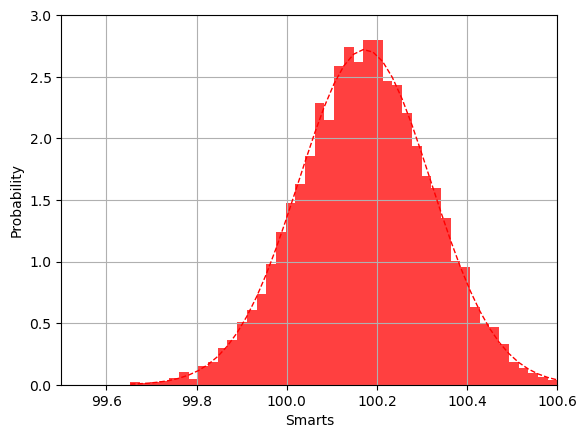

In [6]:

%matplotlib inline

from numpy import *
from numpy.random import randint, randn
from time import time
from scipy.stats import norm
import matplotlib.pyplot as plt

# Returns mean of bootstrap samples                                                                                                                                                
def stat(data):
    return mean(data)

# Bootstrap algorithm                                                                                                                                                              
def bootstrap(data, statistic, R):
    t = zeros(R); n = len(data); inds = arange(n); t0 = time()

    # non-parametric bootstrap                                                                                                                                                     
    for i in range(R):
        t[i] = statistic(data[randint(0,n,n)])

    # analysis                                                                                                                                                                     
    print("Runtime: %g sec" % (time()-t0)); print("Bootstrap Statistics :")
    print("original           bias      std. error")
    print("%8g %8g %14g %15g" % (statistic(data), std(data),\
                             mean(t), \
                             std(t)))
    return t


mu, sigma = 100, 15
datapoints = 10000
x = mu + sigma*random.randn(datapoints)
# bootstrap returns the data sample                                                                                                          t = bootstrap(x, stat, datapoints)
# the histogram of the bootstrapped  data  
t = bootstrap(x, stat, datapoints)
# the histogram of the bootstrapped  data                                            
n, binsboot, patches = plt.hist(t, bins=50, density='true',histtype='bar', color='red', alpha=0.75)

# add a 'best fit' line                                                                                                                                                          
y = norm.pdf( binsboot, mean(t), std(t))
lt = plt.plot(binsboot, y, 'r--', linewidth=1)
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.axis([99.5, 100.6, 0, 3.0])
plt.grid(True)

plt.show()

## Resampling methods: Blocking

The blocking method was made popular by [Flyvbjerg and Pedersen (1989)](https://aip.scitation.org/doi/10.1063/1.457480)
and has become one of the standard ways to estimate
$V(\widehat{\theta})$ for exactly one $\widehat{\theta}$, namely
$\widehat{\theta} = \overline{X}$. 

Assume $n = 2^d$ for some integer $d>1$ and $X_1,X_2,\cdots, X_n$ is a stationary time series to begin with. 
Moreover, assume that the time series is asymptotically uncorrelated. We switch to vector notation by arranging $X_1,X_2,\cdots,X_n$ in an $n$-tuple. Define:

$$
\begin{align*}
\hat{X} = (X_1,X_2,\cdots,X_n).
\end{align*}
$$

The strength of the blocking method is when the number of
observations, $n$ is large. For large $n$, the complexity of dependent
bootstrapping scales poorly, but the blocking method does not,
moreover, it becomes more accurate the larger $n$ is.

## Blocking Transformations
 We now define
blocking transformations. The idea is to take the mean of subsequent
pair of elements from $\vec{X}$ and form a new vector
$\vec{X}_1$. Continuing in the same way by taking the mean of
subsequent pairs of elements of $\vec{X}_1$ we obtain $\vec{X}_2$, and
so on. 
Define $\vec{X}_i$ recursively by:

$$
(\vec{X}_0)_k \equiv (\vec{X})_k \nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="_auto10"></div>

$$
\begin{equation} 
(\vec{X}_{i+1})_k \equiv \frac{1}{2}\Big( (\vec{X}_i)_{2k-1} +
(\vec{X}_i)_{2k} \Big) \qquad \text{for all} \qquad 1 \leq i \leq d-1
\label{_auto10} \tag{22}
\end{equation}
$$

The quantity $\vec{X}_k$ is
subject to $k$ **blocking transformations**.  We now have $d$ vectors
$\vec{X}_0, \vec{X}_1,\cdots,\vec X_{d-1}$ containing the subsequent
averages of observations. It turns out that if the components of
$\vec{X}$ is a stationary time series, then the components of
$\vec{X}_i$ is a stationary time series for all $0 \leq i \leq d-1$

We can then compute the autocovariance, the variance, sample mean, and
number of observations for each $i$. 
Let $\gamma_i, \sigma_i^2,
\overline{X}_i$ denote the autocovariance, variance and average of the
elements of $\vec{X}_i$ and let $n_i$ be the number of elements of
$\vec{X}_i$. It follows by induction that $n_i = n/2^i$.

## Blocking Transformations

Using the
definition of the blocking transformation and the distributive
property of the covariance, it is clear that since $h =|i-j|$
we can define

$$
\gamma_{k+1}(h) = cov\left( ({X}_{k+1})_{i}, ({X}_{k+1})_{j} \right) \nonumber
$$

$$
=  \frac{1}{4}cov\left( ({X}_{k})_{2i-1} + ({X}_{k})_{2i}, ({X}_{k})_{2j-1} + ({X}_{k})_{2j} \right) \nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="_auto11"></div>

$$
\begin{equation} 
=  \frac{1}{2}\gamma_{k}(2h) + \frac{1}{2}\gamma_k(2h+1) \hspace{0.1cm} \mathrm{h = 0} 
\label{_auto11} \tag{23}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto12"></div>

$$
\begin{equation} 
=\frac{1}{4}\gamma_k(2h-1) + \frac{1}{2}\gamma_k(2h) + \frac{1}{4}\gamma_k(2h+1) \quad \mathrm{else}
\label{_auto12} \tag{24}
\end{equation}
$$

The quantity $\hat{X}$ is asymptotic uncorrelated by assumption, $\hat{X}_k$ is also asymptotic uncorrelated. Let's turn our attention to the variance of the sample mean $V(\overline{X})$.

## Blocking Transformations, getting there
We have

<!-- Equation labels as ordinary links -->
<div id="_auto13"></div>

$$
\begin{equation}
V(\overline{X}_k) = \frac{\sigma_k^2}{n_k} + \underbrace{\frac{2}{n_k} \sum_{h=1}^{n_k-1}\left( 1 - \frac{h}{n_k} \right)\gamma_k(h)}_{\equiv e_k} = \frac{\sigma^2_k}{n_k} + e_k \quad \text{if} \quad \gamma_k(0) = \sigma_k^2. 
\label{_auto13} \tag{25}
\end{equation}
$$

The term $e_k$ is called the **truncation error**:

<!-- Equation labels as ordinary links -->
<div id="_auto14"></div>

$$
\begin{equation}
e_k = \frac{2}{n_k} \sum_{h=1}^{n_k-1}\left( 1 - \frac{h}{n_k} \right)\gamma_k(h). 
\label{_auto14} \tag{26}
\end{equation}
$$

We can show that $V(\overline{X}_i) = V(\overline{X}_j)$ for all $0 \leq i \leq d-1$ and $0 \leq j \leq d-1$.

## Blocking Transformations, final expressions

We can then wrap up

$$
n_{j+1} \overline{X}_{j+1}  = \sum_{i=1}^{n_{j+1}} (\hat{X}_{j+1})_i =  \frac{1}{2}\sum_{i=1}^{n_{j}/2} (\hat{X}_{j})_{2i-1} + (\hat{X}_{j})_{2i} \nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="_auto15"></div>

$$
\begin{equation} 
= \frac{1}{2}\left[ (\hat{X}_j)_1 + (\hat{X}_j)_2 + \cdots + (\hat{X}_j)_{n_j} \right] = \underbrace{\frac{n_j}{2}}_{=n_{j+1}} \overline{X}_j = n_{j+1}\overline{X}_j. 
\label{_auto15} \tag{27}
\end{equation}
$$

By repeated use of this equation we get $V(\overline{X}_i) = V(\overline{X}_0) = V(\overline{X})$ for all $0 \leq i \leq d-1$. This has the consequence that

<!-- Equation labels as ordinary links -->
<div id="eq:convergence"></div>

$$
\begin{equation}
V(\overline{X}) = \frac{\sigma_k^2}{n_k} + e_k \qquad \text{for all} \qquad 0 \leq k \leq d-1. \label{eq:convergence} \tag{28}
\end{equation}
$$

Flyvbjerg and Petersen demonstrated that the sequence
$\{e_k\}_{k=0}^{d-1}$ is decreasing, and conjecture that the term
$e_k$ can be made as small as we would like by making $k$ (and hence
$d$) sufficiently large. The sequence is decreasing (Master of Science thesis by Marius Jonsson, UiO 2018).
It means we can apply blocking transformations until
$e_k$ is sufficiently small, and then estimate $V(\overline{X})$ by
$\widehat{\sigma}^2_k/n_k$. 

For an elegant solution and proof of the blocking method, see the recent article of [Marius Jonsson (former MSc student of the Computational Physics group)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.98.043304).